In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
pd.read_excel('../data/competitions/elo-merchant-category-recommendation/Data Dictionary.xlsx', header=2, sheet_name='train')

,Columns,Description
0,card_id,Unique card identifier
1,first_active_month,"'YYYY-MM', month of first purchase"
2,feature_1,Anonymized card categorical feature
3,feature_2,Anonymized card categorical feature
4,feature_3,Anonymized card categorical feature
5,target,Loyalty numerical score calculated 2 months af...


- sample_submission: 正确提交结果范例

In [3]:
pd.read_csv('../data/competitions/elo-merchant-category-recommendation/sample_submission.csv', header=0).head(5)

,card_id,target
0,C_ID_0ab67a22ab,0
1,C_ID_130fd0cbdd,0
2,C_ID_b709037bc5,0
3,C_ID_d27d835a9f,0
4,C_ID_2b5e3df5c2,0


In [4]:
pd.read_csv('../data/competitions/elo-merchant-category-recommendation/sample_submission.csv', header=0).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123623 entries, 0 to 123622
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   card_id  123623 non-null  object
 1   target   123623 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.9+ MB


最终提交结果格式：id+“对应预测结果”的格式

实际上需要预测每个card_id的用户忠诚度评分。

kaggle主页有结果格式和评估指标：

$$
RMSE=\sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i-\hat{y}_i)^2}
$$

比赛的必要数据：train和test。
特征一致，极简情况下，可以直接在train上训练模型，在test上进行预测。

补充数据集，history_..., new_..., merchants.csv

前两个记录了训练集和测试集信用卡的消费记录，最后一个是前两个数据集中商铺信息（某特征）的进一步解释。

实际建模时，使用更多数据集的相关信息，然后再进一步探索其他三个补充数据集

## 二 train和test

首先数据读取，考虑到数据集较大，提前导入gc包进行内存管理。

实际清理内存时，先del删除对象，再gc.collect()，以手动清理内存

In [5]:
import gc

数据读取

In [6]:
train = pd.read_csv('../data/competitions/elo-merchant-category-recommendation/train.csv')
test = pd.read_csv('../data/competitions/elo-merchant-category-recommendation/test.csv')

In [7]:
# 查看规模
train.shape, test.shape

((201917, 6), (123623, 5))

train多了标签列，比赛的测试集是没有标签的

- train
基本情况：

In [8]:
train.head(5)

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


feature1, 2, 3 官方没有解释，看着办

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   first_active_month  201917 non-null  object 
 1   card_id             201917 non-null  object 
 2   feature_1           201917 non-null  int64  
 3   feature_2           201917 non-null  int64  
 4   feature_3           201917 non-null  int64  
 5   target              201917 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 9.2+ MB


注意，object类没法直接建模

In [10]:
pd.read_excel('../data/competitions/elo-merchant-category-recommendation/Data Dictionary.xlsx', header=2, sheet_name='train')

,Columns,Description
0,card_id,Unique card identifier
1,first_active_month,"'YYYY-MM', month of first purchase"
2,feature_1,Anonymized card categorical feature
3,feature_2,Anonymized card categorical feature
4,feature_3,Anonymized card categorical feature
5,target,Loyalty numerical score calculated 2 months af...


匿名特征可能是自然渠道采集，然后脱敏；或是人工合成

- test

In [11]:
test.head(5)

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04,C_ID_0ab67a22ab,3,3,1
1,2017-01,C_ID_130fd0cbdd,2,3,0
2,2017-08,C_ID_b709037bc5,5,1,1
3,2017-12,C_ID_d27d835a9f,2,1,0
4,2015-12,C_ID_2b5e3df5c2,5,1,1


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123623 entries, 0 to 123622
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   first_active_month  123622 non-null  object
 1   card_id             123623 non-null  object
 2   feature_1           123623 non-null  int64 
 3   feature_2           123623 non-null  int64 
 4   feature_3           123623 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 4.7+ MB


各字段一致，但标签不可知，需要再训练集上划分出验证集来进行模型泛化能力

### 2 数据质量分析
验证数据的正确性，检验缺失值、异常值等

最重要的是判断train和test的一致性关系，即是否是采样于同一总体。
然后决定是使用特征工程和建模，还是侧重trick

- 数据正确性校验
数据本身是否符合基本逻辑，如信用卡id作为建模分析的主键，是否唯一，且训练集和测试集无重复id

In [13]:
train['card_id'].nunique() == train.shape[0]

True

In [14]:
test['card_id'].nunique() == test.shape[0]

True

In [15]:
train['card_id'].nunique() + test['card_id'].nunique() == len(set(train['card_id']) | set(test['card_id']))

True

- 数据缺失

In [16]:
train.isnull().sum()

first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
dtype: int64

In [17]:
test.isnull().sum()

first_active_month    1
card_id               0
feature_1             0
feature_2             0
feature_3             0
dtype: int64

- 异常值

可以通过直方图，镶嵌图等

先用describe()来查看

In [18]:
statistics = train['target'].describe()
statistics

count    201917.000000
mean         -0.393636
std           3.850500
min         -33.219281
25%          -0.883110
50%          -0.023437
75%           0.765453
max          17.965068
Name: target, dtype: float64

先看标签列的分布，而不是先处理训练集的特征，是因为不确定是离散型还是连续型

另外，5个分类水平有时也可看作连续型

这里是连续型，可用pdf直方图进行guancha：

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: xlabel='target', ylabel='Count'>

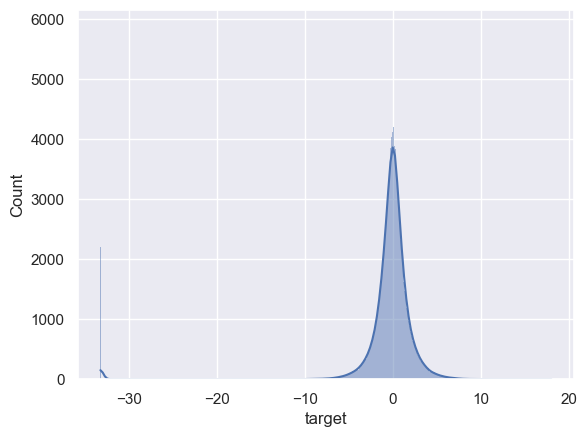

In [20]:
sns.set()
sns.histplot(train['target'], kde=True)

存在异常值在-30以下

其他集中在 [-10, 10]

In [21]:
(train['target'] <= -30).sum()

np.int64(2207)

占整体的1%

对连续变量，可采用$3\delta$原则

In [25]:
statistics.loc['mean'] - 3 * statistics.loc['std']

np.float64(-11.945136285536291)

\>11.95，\<-11.95即可视为异常

- 异常值分析
一般会采用天花板盖帽法，限制取值范围

但是，此处是围绕标签的异常值检测，本例中标签是通过公式人工计算。
出现离群点可能是特殊用户的标记。

所以建模分析时，单独对此类用户进行特征提取、建模分析。

### 4 规律一致性分析

规律一致性：需要对训练集和测试集特征数据的分布进行简单对比，以确定两组数据是否产生于同一总体，即两组数据是否遵循背后总体的规律

虽然ml不强调样本-总体，但
训练集的数据要在测试集上起到预测效果，必须要求受到相同规律影响。

对于标签未知的测试集，可通过特征的分布来判断

- 单变量分析

由于四个变量都是离散型，因此，分布可通过相对占比分布

In [26]:
# 特征别名
features = ['first_active_month', 'feature_1', 'feature_2', 'feature_3']

# 样本总数
train_count = train.shape[0]
test_count = test.shape[0]
train_count, test_count

(201917, 123623)

In [27]:
# 不同取值水平汇总后排序再除以样本总数
train['first_active_month'].value_counts().sort_index()/train_count

first_active_month
2011-11    0.000040
2011-12    0.000010
2012-02    0.000035
2012-03    0.000050
2012-04    0.000089
             ...   
2017-10    0.067825
2017-11    0.064036
2017-12    0.050367
2018-01    0.000168
2018-02    0.000005
Name: count, Length: 75, dtype: float64

<Axes: xlabel='first_active_month'>

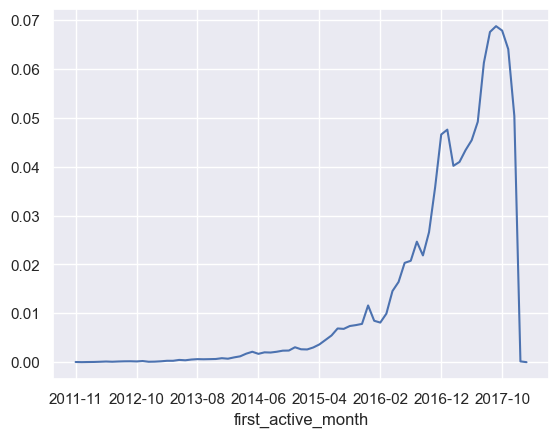

In [28]:
(train['first_active_month'].value_counts().sort_index()/train_count).plot()

同时对比训练集和测试集的4个特征

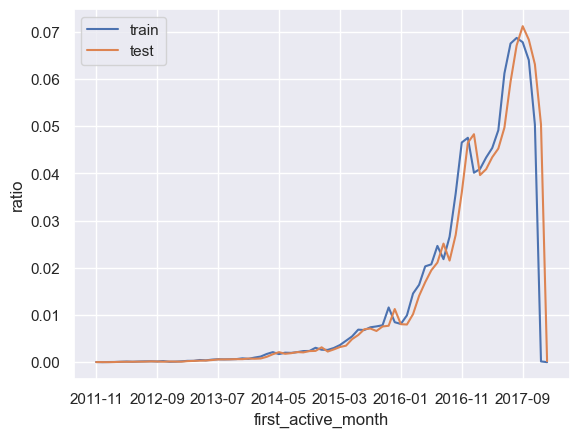

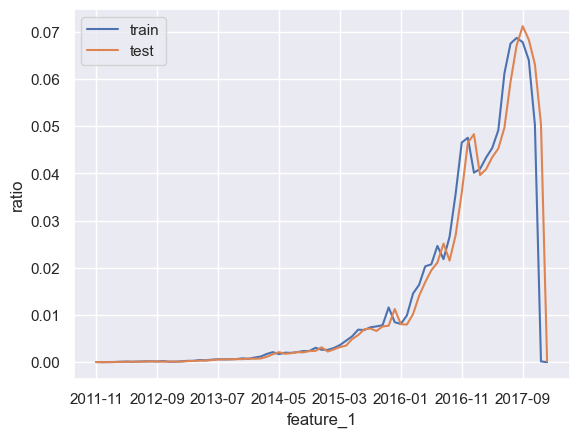

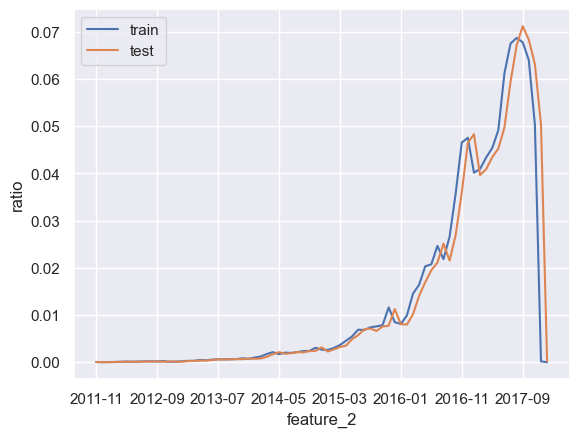

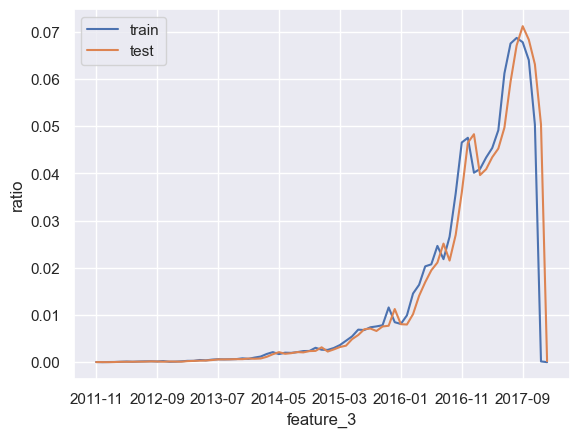

In [29]:
for feature in features:
    (train['first_active_month'].value_counts().sort_index()/train_count).plot()
    (test['first_active_month'].value_counts().sort_index()/test_count).plot()
    plt.legend(['train', 'test'])
    plt.xlabel(feature)
    plt.ylabel('ratio')
    plt.show()